## 테이블 데이터 유사도 측정
테이블 데이터의 메타데이터-제목, 설명, 스키마, 샘플 데이터-를 기반으로 테이블 데이터간 유사도를 측정하고자 한다.

1. 메타데이터 요소별 처리  

	각 요소를 처리하여 벡터화하거나 비교 가능한 형식으로 변환합니다.  

	1.1. 제목 및 설명  

	* 텍스트 데이터로 간주하고 텍스트 유사도 측정 기법 적용:  
	* TF-IDF 벡터화 후 코사인 유사도 계산.  
	* Sentence Embedding(BERT 등)을 사용하여 문장 수준 의미를 비교.  

	1.2. 스키마 (Schema)  

	* 스키마(열 이름, 데이터 타입 등)를 집합(set)으로 처리:  
	* 자카드 유사도를 이용하여 스키마의 교집합/합집합 비율 계산.  
	* 스키마 이름을 임베딩(Word2Vec, BERT 등)하여 유사도 계산.  

	1.3. 샘플 데이터  

	* 데이터가 수치적/범주적/텍스트인지에 따라 처리 방법 변경:  
	* 수치적 데이터: 평균, 표준편차, 분포의 Wasserstein 거리 계산.  
	* 범주형 데이터: 빈도분포를 비교하거나 자카드 유사도 계산.  
	* 텍스트 데이터: 텍스트 유사도 측정 기법 적용.

2. 유사도 통합  

	모든 요소의 유사도를 개별적으로 계산한 후, 가중합(weighted sum)을 통해 최종 유사도 점수 도출:
	* $ \text{Final Similarity} = w_1 \cdot \text{Title Similarity} + w_2 \cdot \text{Description Similarity} + w_3 \cdot \text{Schema Similarity} + w_4 \cdot \text{Sample Similarity} $
	* $ w_1, w_2, w_3, w_4 : 각 요소의 중요도를 나타내는 가중치. $

In [17]:
# 필요한 라이브러리 설치 
!pip install scikit-learn requests pandas sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# 샘플 메타데이터
table1 = {
    "title": "매출 데이터",
    "description": "북미 지역의 분기별 매출 데이터",  # 한글 설명
    "schema": ["지역", "상품", "매출", "분기"],  # 한글 스키마
    "sample_data": [
        {"지역": "NA", "상품": "A", "매출": 100, "분기": "Q1"},
        {"지역": "NA", "상품": "B", "매출": 200, "분기": "Q2"}
    ]
}

table2 = {
    "title": "수익 정보",
    "description": "",  # 설명이 비어 있음
    "schema": ["지역", "항목", "수익", "분기"],  # 다른 한글 스키마
    "sample_data": [
        {"지역": "NA", "항목": "A", "수익": 120, "분기": "Q1"},
        {"지역": "NA", "항목": "B", "수익": 220, "분기": "Q2"}
    ]
}

# 1. 제목 유사도 계산
model = SentenceTransformer('all-MiniLM-L6-v2')
title_similarity = cosine_similarity(
    model.encode([table1['title']]), 
    model.encode([table2['title']])
)[0][0]

# 2. 설명 유사도 계산 (비어있는 경우 처리)
desc1 = table1['description'] if table1['description'] else "설명 없음"
desc2 = table2['description'] if table2['description'] else "설명 없음"

description_similarity = cosine_similarity(
    model.encode([desc1]), 
    model.encode([desc2])
)[0][0]

# 3. 스키마 유사도 계산 (자카드 유사도)
schema1 = set(table1['schema'])
schema2 = set(table2['schema'])
schema_similarity = len(schema1 & schema2) / len(schema1 | schema2)

# 4. 샘플 데이터 유사도 계산 (열 이름 비교)
sample_schema1 = set(table1['sample_data'][0].keys())
sample_schema2 = set(table2['sample_data'][0].keys())
sample_similarity = len(sample_schema1 & sample_schema2) / len(sample_schema1 | sample_schema2)

# 5. 공통 사용 기록 유사도 (가정: 사용 기록 추가)
usage_data = {
    "매출 데이터": ["work_001", "work_002", "work_003"],
    "수익 정보": ["work_001", "work_004", "work_003", "work_005"]
}
usage1 = set(usage_data["매출 데이터"])
usage2 = set(usage_data["수익 정보"])
usage_similarity = len(usage1 & usage2) / len(usage1 | usage2)

# 6. 최종 유사도 계산
weights = [0.3, 0.3, 0.2, 0.1, 0.1]  # 가중치 설정
final_similarity = (
    weights[0] * title_similarity +
    weights[1] * description_similarity +
    weights[2] * schema_similarity +
    weights[3] * sample_similarity +
    weights[4] * usage_similarity
)

# 결과 출력
print(f"제목 유사도: {title_similarity:.2f}")
print(f"설명 유사도: {description_similarity:.2f}")
print(f"스키마 유사도: {schema_similarity:.2f}")
print(f"샘플 데이터 유사도: {sample_similarity:.2f}")
print(f"사용 기록 유사도: {usage_similarity:.2f}")
print(f"최종 유사도: {final_similarity:.2f}")

제목 유사도: 0.64
설명 유사도: 0.58
스키마 유사도: 0.33
샘플 데이터 유사도: 0.33
사용 기록 유사도: 0.40
최종 유사도: 0.51


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# 샘플 메타데이터
table1 = {
    "title": "매출 데이터",
    "description": "북미 지역의 분기별 매출 데이터",
    "schema": [
        {"컬럼명": "지역", "데이터타입": "문자열", "길이": 10},
        {"컬럼명": "상품", "데이터타입": "문자열", "길이": 20},
        {"컬럼명": "매출", "데이터타입": "숫자", "길이": 8},
        {"컬럼명": "분기", "데이터타입": "문자열", "길이": 5}
    ],
    "sample_data": [
        {"지역": "NA", "상품": "A", "매출": 100, "분기": "Q1"},
        {"지역": "NA", "상품": "B", "매출": 200, "분기": "Q2"}
    ]
}

table2 = {
    "title": "수익 정보",
    "description": "북미 지역의 분기별 수익 데이터",
    "schema": [
        {"컬럼명": "지역", "데이터타입": "문자열", "길이": 10},
        {"컬럼명": "항목", "데이터타입": "문자열", "길이": 20},
        {"컬럼명": "수익", "데이터타입": "숫자", "길이": 8},
        {"컬럼명": "분기", "데이터타입": "문자열", "길이": 5}
    ],
    "sample_data": [
        {"지역": "NA", "항목": "A", "수익": 120, "분기": "Q1"},
        {"지역": "NA", "항목": "B", "수익": 220, "분기": "Q2"}
    ]
}

# 1. 제목 유사도 계산
model = SentenceTransformer('all-MiniLM-L6-v2')
title_similarity = cosine_similarity(
    model.encode([table1['title']]), 
    model.encode([table2['title']])
)[0][0]

# 2. 설명 유사도 계산
desc1 = table1['description'] if table1['description'] else "설명 없음"
desc2 = table2['description'] if table2['description'] else "설명 없음"

description_similarity = cosine_similarity(
    model.encode([desc1]), 
    model.encode([desc2])
)[0][0]

datatype_mapping = {
    "문자열": {"문자열", "TEXT", "CHAR", "VARCHAR"},
    "숫자": {"숫자", "INTEGER", "BIGINT", "FLOAT", "DECIMAL"},
    "날짜": {"DATE", "DATETIME", "TIMESTAMP"}
}

def compare_datatypes(dtype1, dtype2):
    for group, types in datatype_mapping.items():
        if dtype1 in types and dtype2 in types:
            return 1  # 완전히 유사
    return 0  # 유사하지 않음

def compare_lengths(length1, length2):
    max_length = max(length1, length2)
    return 1 - abs(length1 - length2) / max_length if max_length > 0 else 1

# 3. 스키마 유사도 계산
def calculate_schema_similarity(schema1, schema2):
    # 3.1 컬럼명 비교
    columns1 = {col["컬럼명"] for col in schema1}
    columns2 = {col["컬럼명"] for col in schema2}
    column_name_similarity = len(columns1 & columns2) / len(columns1 | columns2)

    # 3.2 데이터타입 비교
    type_matches = sum(
        compare_datatypes(col1["데이터타입"], col2["데이터타입"])
        for col1 in schema1 for col2 in schema2
        if col1["컬럼명"] == col2["컬럼명"]
    )
    type_similarity = type_matches / max(len(schema1), len(schema2))

    # 3.3 길이 비교
    length_similarities = [
        compare_lengths(col1["길이"], col2["길이"])
        for col1 in schema1 for col2 in schema2
        if col1["컬럼명"] == col2["컬럼명"]
    ]
    length_similarity = sum(length_similarities) / len(length_similarities) if length_similarities else 0
    # 평균 스키마 유사도
    return (column_name_similarity + type_similarity + length_similarity) / 3

schema_similarity = calculate_schema_similarity(table1['schema'], table2['schema'])

# 4. 샘플 데이터 유사도 계산 (열 이름 비교)
sample_schema1 = set(table1['sample_data'][0].keys())
sample_schema2 = set(table2['sample_data'][0].keys())
sample_similarity = len(sample_schema1 & sample_schema2) / len(sample_schema1 | sample_schema2)

# 5. 최종 유사도 계산
weights = [0.3, 0.3, 0.3, 0.1]  # 가중치 설정
final_similarity = (
    weights[0] * title_similarity +
    weights[1] * description_similarity +
    weights[2] * schema_similarity +
    weights[3] * sample_similarity
)

# 결과 출력
print(f"제목 유사도: {title_similarity:.2f}")
print(f"설명 유사도: {description_similarity:.2f}")
print(f"스키마 유사도: {schema_similarity:.2f}")
print(f"샘플 데이터 유사도: {sample_similarity:.2f}")
print(f"최종 유사도: {final_similarity:.2f}")

제목 유사도: 0.64
설명 유사도: 0.99
스키마 유사도: 0.61
샘플 데이터 유사도: 0.33
최종 유사도: 0.71


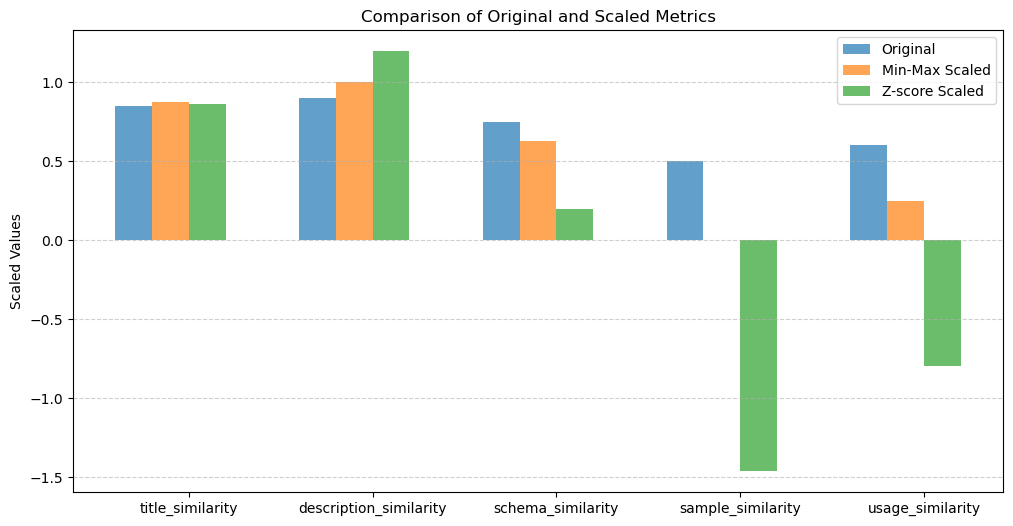

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# 예제 데이터: 여러 메트릭의 유사도 결과값
raw_scores = {
    "title_similarity": 0.85,
    "description_similarity": 0.90,
    "schema_similarity": 0.75,
    "sample_similarity": 0.50,
    "usage_similarity": 0.60
}

# 1. Min-Max 스케일링
scaler = MinMaxScaler()
minmax_scaled = scaler.fit_transform(np.array(list(raw_scores.values())).reshape(-1, 1)).flatten()

# 2. Z-score 스케일링
zscore_scaled = StandardScaler().fit_transform(np.array(list(raw_scores.values())).reshape(-1, 1)).flatten()

# 3. 시각화
categories = list(raw_scores.keys())
x = np.arange(len(categories))

plt.figure(figsize=(12, 6))

# 원본 점수
plt.bar(x - 0.3, list(raw_scores.values()), width=0.2, label='Original', alpha=0.7)

# Min-Max 스케일링
plt.bar(x - 0.1, minmax_scaled, width=0.2, label='Min-Max Scaled', alpha=0.7)

# Z-score 스케일링
plt.bar(x + 0.1, zscore_scaled, width=0.2, label='Z-score Scaled', alpha=0.7)

# 설정
plt.xticks(x, categories)
plt.title("Comparison of Original and Scaled Metrics")
plt.ylabel("Scaled Values")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()